In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from vivarium.test_util import setup_simulation, pump_simulation

pd.set_option('display.max_rows', 8)

!date

Thu Mar  8 20:03:05 PST 2018


# Modeling SIR infections in Vivarium

In [7]:
import vivarium, vivarium.test_util as vtu

np.random.seed(12345)  # set random seed for reproducibility

n_simulants = 300
n_days = 1000
t_timestep = 1 # days
t_start = pd.Timestamp('1990-01-01')

# Model One: doing it all by hand

In [12]:
class SI1:
    def setup(self, builder):
        self.population_view = builder.population.get_view(['disease_state'])
        builder.population.initializes_simulants(self.initialize_simulants, creates_columns=['disease_state'])
        self.beta = 1.1
        
        builder.event.register_listener('time_step', self.on_time_step)
        
    def initialize_simulants(self, pop_data):
        """Start most simulants in susceptible state, but one in infected"""
        disease_state = pd.Series('S', index=pop_data.index, name='disease_state')
        disease_state[0] = 'I'
        
        self.population_view.update(disease_state)
        
    def on_time_step(self, event):
        """one step of infectious disease dynamics"""
        pop = self.population_view.get(event.index)
        infected_proportion = np.mean(pop.disease_state == 'I')
        
        rows = (np.random.uniform(size=len(event.index)) < self.beta * infected_proportion)
        pop.disease_state[rows] = 'I'
        self.population_view.update(pop)
        

In [13]:
sim = setup_simulation([SI1()], population_size=n_simulants, start=t_start)
pump_simulation(sim, time_step_days=t_timestep, duration=4)

VBox(children=(HTML(value=''), IntProgress(value=0, max=4)))

4

In [14]:
sim.population.population.disease_state.value_counts()

S    275
I     25
Name: disease_state, dtype: int64

In [17]:
# take a look at this, but how
class SIObserver:
    def __init__(self):
        """initialize some dictionaries to hold observations
        """
        self.S = {}
        self.I = {}
        
    def setup(self, builder):
        """get a population view in setup instead of in __init__,
        because it comes from the simulation's builder object
        """
        self.population_view = builder.population.get_view(['disease_state'])
        
        builder.event.register_listener('collect_metrics', self.on_collect_metrics)
        
    def on_collect_metrics(self, event):
        """after every time step the simulation engine sends 
        a collect_metrics event, which is the perfect time
        to record some statistics about the state of the simulation
        """
        
        pop = self.population_view.get(event.index)
        self.S[event.time] = np.sum(pop.disease_state == 'S')
        self.I[event.time] = np.sum(pop.disease_state == 'I')

    def show(self):
        """simple plot of observations
        """
        pd.DataFrame([self.S, self.I]).T.plot(marker='s')

In [18]:
o = SIObserver()
sim = setup_simulation([SI1(), o], population_size=n_simulants, start=t_start)
pump_simulation(sim, time_step_days=t_timestep, duration=15)

VBox(children=(HTML(value=''), IntProgress(value=0, max=15)))

15

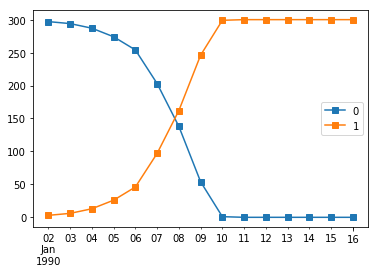

In [19]:
o.show()

# Model Two: use `vivarium` randomness
Better than using `np.random` directly.

VBox(children=(HTML(value=''), IntProgress(value=0, max=15)))

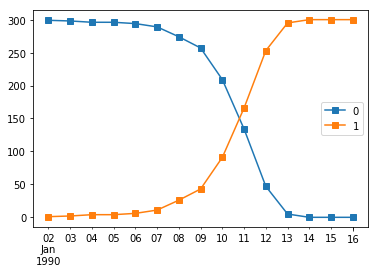

In [23]:
class SI2:
    def setup(self, builder):
        """new this time: use builder.randomness to create a random number stream
        """
        self.population_view = builder.population.get_view(['disease_state'])
        self.beta = 1.1

        self.randomness = builder.randomness.get_stream('infection')
    
    @listens_for('initialize_simulants')
    def on_initalize_simulants(self, event):
        """Start most simulants in susceptible state, but one in infected
        """
        disease_state = pd.Series('S', index=event.index, name='disease_state')
        disease_state[0] = 'I'
        
        self.population_view.update(disease_state)
    
    @listens_for('time_step')
    def on_time_step(self, event):
        """one step of infectious disease dynamics, now implemented with
        randomness method provided by vivarium"""
        pop = self.population_view.get(event.index)
        infected_proportion = np.mean(pop.disease_state == 'I')

        infected = self.randomness.filter_for_probability(pop, self.beta * infected_proportion)
        infected = infected.copy()  # HACK: makes a SettingWithCopyWarning go away
        infected.disease_state = 'I'
        self.population_view.update(infected)
        
o = SIObserver()
sim = vtu.setup_simulation([SI2(), o], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=15)
o.show()

In [24]:
# now the randomness is replicable, you don't need to set the random seed anymore
sim = vtu.setup_simulation([SI2()], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=10)

sim.population.population.disease_state.value_counts()

VBox(children=(HTML(value=''), IntProgress(value=0, max=10)))

I    166
S    134
Name: disease_state, dtype: int64

In [25]:
# do it again, get exactly same results

sim = vtu.setup_simulation([SI2()], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=10)

sim.population.population.disease_state.value_counts()

VBox(children=(HTML(value=''), IntProgress(value=0, max=10)))

I    166
S    134
Name: disease_state, dtype: int64

# Model Three: use randomness and pipelines

In [21]:
class SI3:
    def setup(self, builder):
        self.population_view = builder.population.get_view(['disease_state'])
        builder.population.initializes_simulants(self.initialize_simulants, creates_columns=['disease_state'])
        self.beta = 1.1
        
        builder.event.register_listener('time_step__prepare', self.on_time_step__prepare)
        builder.event.register_listener('time_step', self.on_time_step)

        self.randomness = builder.randomness.get_stream('infection')
        self.infection_prob = builder.value.register_value_producer('infection_prob', 
                                                                    source=self.infection_prob_func)
    
    def initialize_simulants(self, pop_data):
        """Start most simulants in susceptible state, but one in infected
        """
        disease_state = pd.Series('S', index=pop_data.index, name='disease_state')
        disease_state[0] = 'I'
        
        self.population_view.update(disease_state)

    def on_time_step__prepare(self, event):
        """count number infected"""
        pop = self.population_view.get(event.index)
        self.infected_proportion = np.mean(pop.disease_state == 'I')
    
    def infection_prob_func(self, index):
        return pd.Series(self.beta * self.infected_proportion, index=index)
    
    def on_time_step(self, event):
        pop = self.population_view.get(event.index)
        infected = self.randomness.filter_for_probability(pop, self.infection_prob(event.index))
        infected = infected.copy()  # makes a SettingWithCopyWarning go away
        infected.disease_state = 'I'
        self.population_view.update(infected)
        


VBox(children=(HTML(value=''), IntProgress(value=0, max=15)))

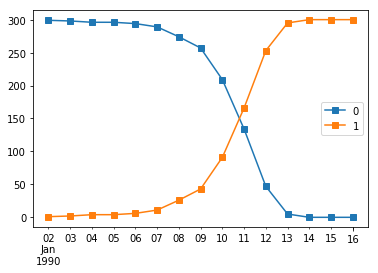

In [22]:
o = SIObserver()
sim = vtu.setup_simulation([SI3(), o], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=15)
o.show()

Seems like more work for no gain... What is the point of the pipeline?  Modularity and composability.

Introduce a vaccine component:

In [31]:
class Vaccine:
    def setup(self, builder):
        self.population_view = builder.population.get_view(['vaccine_protection'])
        builder.population.initializes_simulants(self.initialize_simulants, 
                                                 creates_columns=['vaccine_protection'])
        builder.value.register_value_modifier('infection_prob', self.modify_infection_prob)
        
        self.randomness = builder.randomness.get_stream('vaccine_protection')

    def initialize_simulants(self, pop_data):
        s = self.randomness.get_draw(pop_data.index)
        s[:] = np.where(s>.8, 1, s)
        self.population_view.update(s)
        
    def modify_infection_prob(self, index, value):
        pop = self.population_view.get(index)
        return value*(1 - pop.vaccine_protection)

VBox(children=(HTML(value=''), IntProgress(value=0, max=25)))

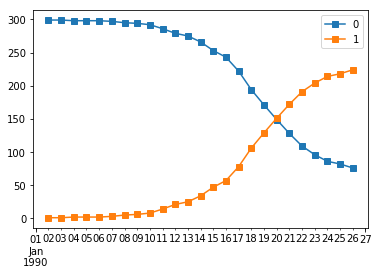

In [32]:
o = SIObserver()
sim = vtu.setup_simulation([SI3(), Vaccine(), o], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=25)
o.show()

In [33]:
df = sim.population.population
df.disease_state.value_counts()

I    224
S     76
Name: disease_state, dtype: int64

In [34]:
g = df.groupby(pd.cut(df.vaccine_protection, bins=4))
t = g.disease_state.value_counts(normalize=True).unstack().fillna(0)
np.round(100*t, 1)

disease_state,I,S
vaccine_protection,,
"(-0.000438, 0.25]",100.0,0.0
"(0.25, 0.5]",98.4,1.6
"(0.5, 0.75]",91.4,8.6
"(0.75, 1.0]",17.1,82.9
